<a href="https://colab.research.google.com/github/Humayun002/museum-review-analysis/blob/main/Museum_NLP_Full_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')
# nltk.download('vader_lexicon')
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# !pip install langdetect
# !pip install emoji
# !pip install transformers
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import re
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from google.colab import files
uploaded = files.upload()

Saving clean_reviews.csv to clean_reviews (9).csv


In [3]:
df = pd.read_csv('clean_reviews.csv')
df = df[['Title', 'Text']]
df

,Title,Text
0,Well worth a visit,"Always worth a visit to see the collection, to..."
1,Simply love this place,"An absolute delight, totally worth the visit. ..."
2,More 'Shart' than 'Art',"Noting that art appreciation is subjective, th..."
3,Wonderful Museum,Can’t believe I saw Starry Night ✨\n\n- Wonder...
4,Poorly managed museum with a great collection,"I am not an art expert, but love learning abou..."
...,...,...
9689,"If you have little time, it's better to spend ...",I expected the part dedicated to contemporary ...
9690,Great museum of modern art,It is really a modern art museum and not like ...
9691,Great museum in the part we could understand,"In fact, we spent more time on the 5th and 4th..."
9692,Confusion,"There's no question of art... organization, ho..."


In [4]:
stopwords = set(stopwords.words('english')) | {
    'a', 'about', 'above', 'again', 'all', 'am', 'an', 'and', 'any', 'as', 'at',
    'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'by',
    'doing', 'during', 'each', 'from', 'further', 'he', 'her', 'here', 'hers',
    'herself', 'him', 'himself', 'his', 'i', 'in', 'into', 'is', 'it', "it's",
    'its', 'itself', 'me', 'my', 'myself', 'of', 'off', 'on', 'once', 'or',
    'our', 'ours', 'ourselves', 'own', 's', 'she', "she's", 'some', 't', 'that',
    "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there',
    'these', 'they', 'this', 'those', 'through', 'to', 'up', 'we', 'were',
    'while', 'will', 'with', 'you', "you'd", "you'll", "you're", "you've", 'your',
    'yours', 'yourself', 'yourselves'
}
# stopwords = set(stopwords.words('english'))

In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Handle empty or invalid input
    if not text or not isinstance(text, str):
        return ''

    # Detect language and filter non-English tweets
    try:
        if detect(text) != 'en':
            return ''
    except LangDetectException:
        return ''

    # Convert text to lowercase
    text = text.lower()

    # Remove URLs, mentions, and unwanted characters
    text = re.sub(r'https?://\S+|www\.\S+|@\w+|[^a-zA-Z\s]', ' ', text).strip()

    # Convert emojis to text
    text = emoji.demojize(text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # Reduce repeated characters (e.g., "cooooool" -> "cool")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Split concatenated camel-case or Pascal-case words
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)

    # Tokenize and process words
    tokens = text.split()

    # Remove short tweets and nonsense (e.g., "hello hello hello")
    if len(tokens) < 2 or len(set(tokens)) == 1:
        return ''

    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if 2 < len(word) <= 17 and word not in stopwords
    ]

    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_text'] = df['Text'].apply(lambda x: preprocess(x))

df = df.reset_index(drop=True)

print(df['cleaned_text'])

0       always worth visit see collection say nothing ...
1       absolute delight totally worth visit expected ...
2       noting art appreciation subjective lovely nota...
3       believe saw starry night wonderful gift shop g...
4       art expert love learning art disappointed way ...
                              ...                        
9689    expected part dedicated contemporary art riche...
9690    really modern art museum like others pretend c...
9691    fact spent time floor painting dali frida gall...
9692    question art organization however another thin...
9693    say yet said written number painting richness ...
Name: cleaned_text, Length: 9694, dtype: object


In [6]:
# Tokenize the OriginalTweet column
df['Tokenized_Text'] = df['cleaned_text'].apply(
    lambda x: word_tokenize(x) if isinstance(x, str) and x.strip() else []
)

# Display the original and tokenized versions of the first few rows
df[['cleaned_text', 'Tokenized_Text']].head()

,cleaned_text,Tokenized_Text
0,always worth visit see collection say nothing ...,"[always, worth, visit, see, collection, say, n..."
1,absolute delight totally worth visit expected ...,"[absolute, delight, totally, worth, visit, exp..."
2,noting art appreciation subjective lovely nota...,"[noting, art, appreciation, subjective, lovely..."
3,believe saw starry night wonderful gift shop g...,"[believe, saw, starry, night, wonderful, gift,..."
4,art expert love learning art disappointed way ...,"[art, expert, love, learning, art, disappointe..."


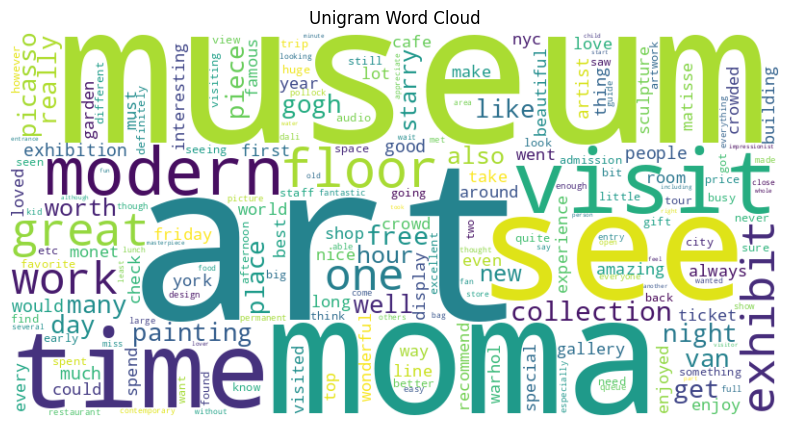

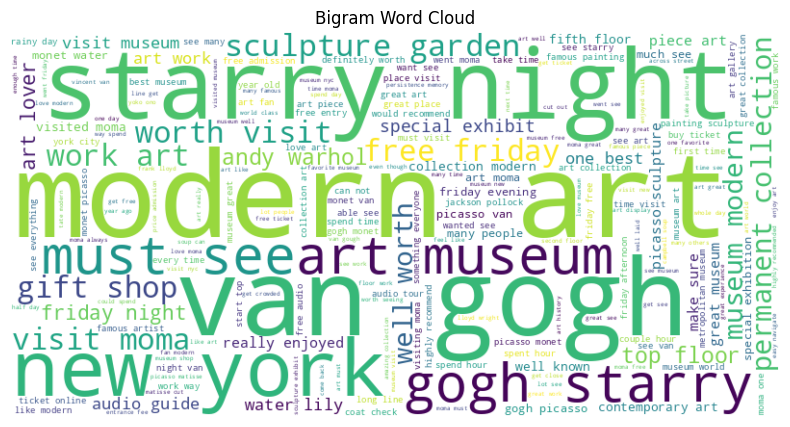

In [7]:
# Combine all cleaned tokens into a single list for analysis
all_tokens = [word for tokens in df['Tokenized_Text'] for word in tokens]

# Frequency analysis of unigrams
unigram_freq = Counter(all_tokens)

# Generate a word cloud for unigrams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.title("Unigram Word Cloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Frequency analysis of bigrams
bigrams = Counter(zip(all_tokens[:-1], all_tokens[1:]))
bigram_freq = {f"{w1} {w2}": count for (w1, w2), count in bigrams.items()}

# Generate a word cloud for bigrams
bigram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)

# Display the bigram cloud
plt.figure(figsize=(10, 5))
plt.title("Bigram Word Cloud")
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment Analysis

In [8]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    if isinstance(text, list):  # Check if it's a list
        text = ' '.join(text)  # Join the list into a string
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['cleaned_text'].apply(get_sentiment)

Sentiment
Positive    9170
Negative     358
Neutral      166
Name: count, dtype: int64


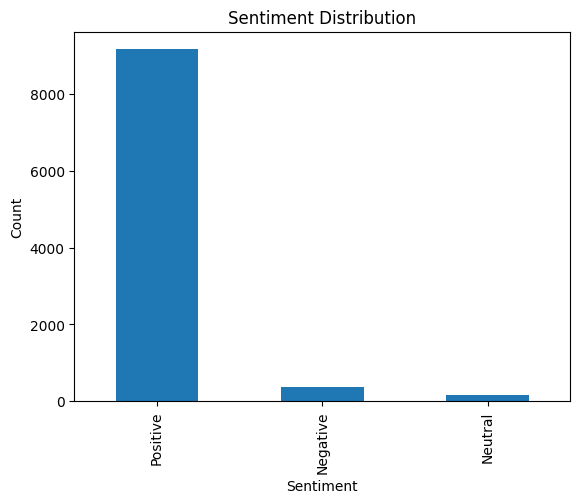

In [9]:
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Emotional Classification

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


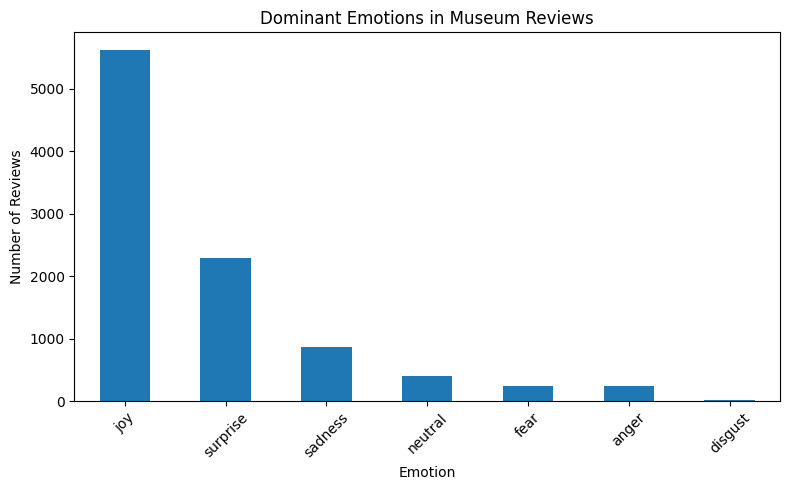

In [10]:
# Initialize the emotion‐classification pipeline
emotion_clf = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True,
    device=0,
    truncation=True,  # Truncate long inputs
    max_length=512, # Set maximum sequence length to 512
)

# Run it over each review and build a DataFrame of emotion scores
def get_emotion_scores(text):
    if not isinstance(text, str) or text.strip()=="":
        return {}
    scores = emotion_clf(text)[0]
    # convert list of dicts to label:score mapping
    return {d['label']: d['score'] for d in scores}

# apply and expand into columns
df_emotion_score = df['cleaned_text'].apply(get_emotion_scores).apply(pd.Series).fillna(0)

# Pick the top emotion for each review
df['dominant_emotion'] = df_emotion_score.idxmax(axis=1)

# Quick visualization of overall emotion distribution
emotion_counts = df['dominant_emotion'].value_counts()

plt.figure(figsize=(8,5))
emotion_counts.plot(kind='bar')
plt.title('Dominant Emotions in Museum Reviews')
plt.xlabel('Emotion')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
df

,Title,Text,cleaned_text,Tokenized_Text,Sentiment,dominant_emotion
0,Well worth a visit,"Always worth a visit to see the collection, to...",always worth visit see collection say nothing ...,"[always, worth, visit, see, collection, say, n...",Positive,joy
1,Simply love this place,"An absolute delight, totally worth the visit. ...",absolute delight totally worth visit expected ...,"[absolute, delight, totally, worth, visit, exp...",Positive,joy
2,More 'Shart' than 'Art',"Noting that art appreciation is subjective, th...",noting art appreciation subjective lovely nota...,"[noting, art, appreciation, subjective, lovely...",Positive,joy
3,Wonderful Museum,Can’t believe I saw Starry Night ✨\n\n- Wonder...,believe saw starry night wonderful gift shop g...,"[believe, saw, starry, night, wonderful, gift,...",Positive,joy
4,Poorly managed museum with a great collection,"I am not an art expert, but love learning abou...",art expert love learning art disappointed way ...,"[art, expert, love, learning, art, disappointe...",Negative,sadness
...,...,...,...,...,...,...
9689,"If you have little time, it's better to spend ...",I expected the part dedicated to contemporary ...,expected part dedicated contemporary art riche...,"[expected, part, dedicated, contemporary, art,...",Positive,surprise
9690,Great museum of modern art,It is really a modern art museum and not like ...,really modern art museum like others pretend c...,"[really, modern, art, museum, like, others, pr...",Positive,surprise
9691,Great museum in the part we could understand,"In fact, we spent more time on the 5th and 4th...",fact spent time floor painting dali frida gall...,"[fact, spent, time, floor, painting, dali, fri...",Negative,surprise
9692,Confusion,"There's no question of art... organization, ho...",question art organization however another thin...,"[question, art, organization, however, another...",Positive,sadness


# Negative Review Analysis

          word  count
3         time    213
4        floor    182
5       people    180
8         work    139
12       staff    108
13       place    107
14        line    106
17      ticket    100
18       piece     96
21  experience     85
23        free     83
24     crowded     78
25        rude     78
26        hour     77
27         lot     77
28       night     75


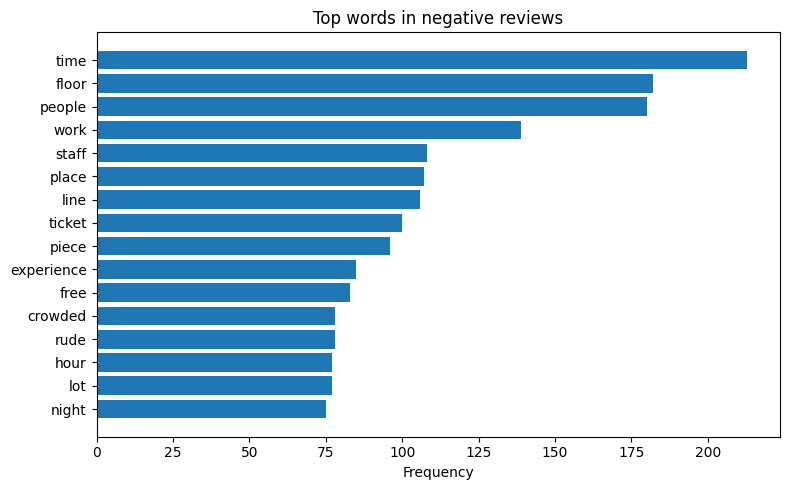

In [12]:
# 1) Filter to negative reviews
#    – assume you have df['sentiment_label'] == 'negative'
neg_df = df[(df['Sentiment'] == 'Negative') | (df['dominant_emotion'] == 'anger') | (df['dominant_emotion'] == 'disguest')].reset_index(drop=True)
# 2) Vectorize and count unigrams
vect = CountVectorizer(stop_words='english',
                       ngram_range=(1,1),
                       min_df=5)             # only words in ≥5 reviews
X_neg = vect.fit_transform(neg_df['cleaned_text'])

# 3) Sum up occurrences and get top-20
sum_counts = X_neg.sum(axis=0).A1
words = vect.get_feature_names_out()
freqs = list(zip(words, sum_counts))
top_words = sorted(freqs, key=lambda x: x[1], reverse=True)[:30]

# 4) Display
top_df = pd.DataFrame(top_words, columns=['word','count'])
exclude = ['art', 'museum', 'moma', 'exhibit', 'painting', 'really', 'like', 'day', 'modern', 'collection', 'visit', 'went', 'new', 'gallery']
top_df = top_df[~top_df['word'].isin(exclude)]
print(top_df)

# 5) (Optional) bar chart
plt.figure(figsize=(8,5))
plt.barh(top_df['word'][::-1], top_df['count'][::-1])
plt.title('Top words in negative reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
neg_df.head(10)

,Title,Text,cleaned_text,Tokenized_Text,Sentiment,dominant_emotion
0,Poorly managed museum with a great collection,"I am not an art expert, but love learning abou...",art expert love learning art disappointed way ...,"[art, expert, love, learning, art, disappointe...",Negative,sadness
1,Only the 5th floor is worth seeing,Mostly rubbish. The 5th floor boasts a collect...,mostly rubbish floor boast collection early mo...,"[mostly, rubbish, floor, boast, collection, ea...",Negative,fear
2,Not so Modern,The word Modern in the name is miss leading. T...,word modern name miss leading art different gu...,"[word, modern, name, miss, leading, art, diffe...",Negative,neutral
3,Bad experience,"bad experience checking my backpack, the rule ...",bad experience checking backpack rule food won...,"[bad, experience, checking, backpack, rule, fo...",Negative,surprise
4,The most rude museum of New York,The Mo.ma is one of the most important museum ...,one important museum contemporary art world al...,"[one, important, museum, contemporary, art, wo...",Positive,anger
5,Not for everyone,It’s a place upto individual tastes . I find s...,place upto individual taste find instillation ...,"[place, upto, individual, taste, find, instill...",Positive,anger
6,An artistic hellhole,This museum needs a managerial consultant to s...,museum need managerial consultant straighten n...,"[museum, need, managerial, consultant, straigh...",Negative,sadness
7,The City of New York should fine MOMA for occu...,I purchased my ticket online this morning. Whe...,purchased ticket online morning arrived line e...,"[purchased, ticket, online, morning, arrived, ...",Negative,surprise
8,Don't miss whatever they have - it will be fab...,"We have visited the MOMA a few times, but it h...",visited moma time since last visit sure allow ...,"[visited, moma, time, since, last, visit, sure...",Negative,joy
9,Francis Bacon,V good experience. One disappointing item I no...,good experience one disappointing item noticed...,"[good, experience, one, disappointing, item, n...",Negative,sadness
